### https://www.kaggle.com/code/billiemage/object-detection/notebook#Extract-info.-from-xml-files


#Install pycoco tools with following command
#!pip install git+https://github.com/gautamchitnis/cocoapi.git@cocodataset-master#subdirectory=PythonAPI

#### Writing a custom dataset for PennFudan


In [191]:
#!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data 
#!cd data && unzip PennFudanPed.zip

In [192]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

In [193]:
image = read_image("./obj_data/Fruits/Train/05_Banana.jpg")


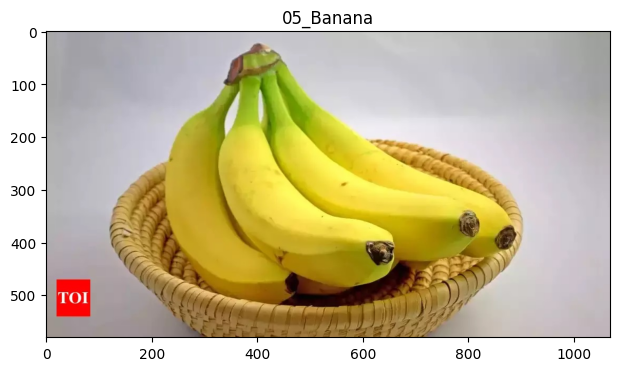

In [194]:
import os
from torchvision.io import read_image
from matplotlib import pyplot as plt
class showImage:
    def __init__(self, img_name):
        self.img_name =  img_name

    def displayImage(self):
        plt.figure(figsize=(16, 8))
        plt.subplot(121)
        image =  read_image(self.img_name)
        plt.title(os.path.splitext(os.path.basename(self.img_name))[0])
        plt.imshow(image.permute(1, 2, 0))
        
si = showImage("./obj_data/Fruits/Train/05_Banana.jpg")
si.displayImage()
    


### Import utilities

In [195]:
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2

from sklearn import preprocessing 


import xml.etree.ElementTree as ET

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SequentialSampler

In [196]:
img_file = 'asdasdasds/asdasda/asdasd/27_apple.jpg'
print(os.path.splitext(os.path.basename(img_file))[0])
print(os.path.splitext(img_file)[0])

27_apple
asdasdasds/asdasda/asdasd/27_apple


### Setup Data loaders

In [197]:
BASE_PATH = "./obj_data/Fruits/Train"
#XML_PATH = os.path.join(BASE_PATH, "Annotations")
IMG_PATH = BASE_PATH
TXT_FILES : list = sorted([os.path.join(BASE_PATH, f) for f in os.listdir(BASE_PATH) if f.lower().endswith(('.txt'))])
IMG_FILES : list = sorted([os.path.join(BASE_PATH, f) for f in os.listdir(BASE_PATH) if f.lower().endswith(('.jpg','.jpeg'))])

#print(len(TXT_FILES))
#print(len(IMG_FILES))

print(IMG_FILES)

['./obj_data/Fruits/Train\\01_Apple.jpg', './obj_data/Fruits/Train\\01_Banana.jpg', './obj_data/Fruits/Train\\01_Grapes.jpg', './obj_data/Fruits/Train\\01_Guava.jpeg', './obj_data/Fruits/Train\\01_HogPulm.jpg', './obj_data/Fruits/Train\\01_Jackfruit.jpg', './obj_data/Fruits/Train\\01_Lichi.jpg', './obj_data/Fruits/Train\\01_Mango.jpg', './obj_data/Fruits/Train\\01_Orange.jpg', './obj_data/Fruits/Train\\01_Papaya.jpeg', './obj_data/Fruits/Train\\02_Apple.jpg', './obj_data/Fruits/Train\\02_Banana.jpg', './obj_data/Fruits/Train\\02_Grapes.jpg', './obj_data/Fruits/Train\\02_Guava.jpeg', './obj_data/Fruits/Train\\02_HogPulm.jpg', './obj_data/Fruits/Train\\02_Jackfruit.jpg', './obj_data/Fruits/Train\\02_Lichi.jpg', './obj_data/Fruits/Train\\02_Mango.jpg', './obj_data/Fruits/Train\\02_Orange.jpeg', './obj_data/Fruits/Train\\02_Papaya.jpg', './obj_data/Fruits/Train\\03_Apple.jpg', './obj_data/Fruits/Train\\03_Banana.jpeg', './obj_data/Fruits/Train\\03_Grapes.jpg', './obj_data/Fruits/Train\\03_

In [198]:
for img_file in TXT_FILES:
    print(img_file)
    directory, base_filename = os.path.split(img_file)
    file_name, file_extension = os.path.splitext(base_filename)
    new_file_name = file_name.replace(" ", "")
    new_file_path = os.path.join(directory, new_file_name + file_extension)
    os.rename(img_file, new_file_path)
    

./obj_data/Fruits/Train\01_Apple.txt
./obj_data/Fruits/Train\01_Banana.txt
./obj_data/Fruits/Train\01_Grapes.txt
./obj_data/Fruits/Train\01_Guava.txt
./obj_data/Fruits/Train\01_HogPulm.txt
./obj_data/Fruits/Train\01_Jackfruit.txt
./obj_data/Fruits/Train\01_Lichi.txt
./obj_data/Fruits/Train\01_Mango.txt
./obj_data/Fruits/Train\01_Orange.txt
./obj_data/Fruits/Train\01_Papaya.txt
./obj_data/Fruits/Train\02_Apple.txt
./obj_data/Fruits/Train\02_Banana.txt
./obj_data/Fruits/Train\02_Grapes.txt
./obj_data/Fruits/Train\02_Guava.txt
./obj_data/Fruits/Train\02_HogPulm.txt
./obj_data/Fruits/Train\02_Jackfruit.txt
./obj_data/Fruits/Train\02_Lichi.txt
./obj_data/Fruits/Train\02_Mango.txt
./obj_data/Fruits/Train\02_Orange.txt
./obj_data/Fruits/Train\02_Papaya.txt
./obj_data/Fruits/Train\03_Apple.txt
./obj_data/Fruits/Train\03_Banana.txt
./obj_data/Fruits/Train\03_Grapes.txt
./obj_data/Fruits/Train\03_Guava.txt
./obj_data/Fruits/Train\03_HogPulm.txt
./obj_data/Fruits/Train\03_Jackfruit.txt
./obj_data

### Extract info. from txt files if not in right format



In [199]:
import re
import pandas as pd
names = []
boxes = []
image_id = []
txt_names = []
img_paths = []
    
class TXTParser():
    def __init__(self, img_file):
        self.img_file = img_file
        
#        si = showImage(img_file)
#        si.displayImage()
        
        self.img_path = img_file
        print(self.img_path)
        self.txt_file = os.path.splitext(img_file)[0] + '.txt'
        self.image_id = os.path.basename(self.img_file)
        self.names = label = (re.search(r"_(.+)\.", os.path.basename(self.img_file)).group(1))
        self.boxes = self._get_bndbox()

    def _get_bndbox(self):
        boxes = []
        with open(self.txt_file, 'r') as f:
            #print(f.readlines())
            box: list = [line.split()[1:] for line in f.readlines()]
            boxes.append(box[0])
        return boxes
    
for img_file in IMG_FILES:
    txt = TXTParser(img_file)
    names.extend([txt.names])
    boxes.extend(txt.boxes)
    image_id.extend([txt.image_id])
    txt_names.extend([txt.txt_file])
    img_paths.extend([txt.img_path])
    
a = {"image_id": image_id,
    "names": names,
    "boxes": boxes,
    "txt_path":txt_names,
    "img_path":img_paths}
    
df = pd.DataFrame.from_dict(a, orient='index')
df = df.transpose()
print(df.head(10))

df['names'].value_counts()
    

./obj_data/Fruits/Train\01_Apple.jpg
./obj_data/Fruits/Train\01_Banana.jpg
./obj_data/Fruits/Train\01_Grapes.jpg
./obj_data/Fruits/Train\01_Guava.jpeg
./obj_data/Fruits/Train\01_HogPulm.jpg
./obj_data/Fruits/Train\01_Jackfruit.jpg
./obj_data/Fruits/Train\01_Lichi.jpg
./obj_data/Fruits/Train\01_Mango.jpg
./obj_data/Fruits/Train\01_Orange.jpg
./obj_data/Fruits/Train\01_Papaya.jpeg
./obj_data/Fruits/Train\02_Apple.jpg
./obj_data/Fruits/Train\02_Banana.jpg
./obj_data/Fruits/Train\02_Grapes.jpg
./obj_data/Fruits/Train\02_Guava.jpeg
./obj_data/Fruits/Train\02_HogPulm.jpg
./obj_data/Fruits/Train\02_Jackfruit.jpg
./obj_data/Fruits/Train\02_Lichi.jpg
./obj_data/Fruits/Train\02_Mango.jpg
./obj_data/Fruits/Train\02_Orange.jpeg
./obj_data/Fruits/Train\02_Papaya.jpg
./obj_data/Fruits/Train\03_Apple.jpg
./obj_data/Fruits/Train\03_Banana.jpeg
./obj_data/Fruits/Train\03_Grapes.jpg
./obj_data/Fruits/Train\03_Guava.jpg
./obj_data/Fruits/Train\03_HogPulm.jpg
./obj_data/Fruits/Train\03_Jackfruit.jpg
./obj

names
Apple        32
Banana       32
Grapes       32
Guava        32
Jackfruit    32
Mango        32
Papaya       32
Orange       32
HogPlum      22
Litchi       22
Lichi        10
HogPulm      10
Name: count, dtype: int64

### Make dataframe from extracted information

In [200]:
# remove .jpg extension from image_id 
df['img_id'] = df['image_id'].apply(lambda x:x.split('.')).map(lambda x:x[0])
df.drop(columns=['image_id'], inplace=True)
print(df.head())



     names                                     boxes  \
0    Apple  [0.275811, 0.539679, 0.230088, 0.376955]   
1   Banana  [0.614642, 0.348451, 0.728077, 0.533186]   
2   Grapes  [0.495575, 0.558628, 0.796460, 0.665929]   
3    Guava  [0.636355, 0.262168, 0.235940, 0.170354]   
4  HogPulm  [0.359587, 0.420354, 0.534907, 0.358407]   

                                 txt_path  \
0    ./obj_data/Fruits/Train\01_Apple.txt   
1   ./obj_data/Fruits/Train\01_Banana.txt   
2   ./obj_data/Fruits/Train\01_Grapes.txt   
3    ./obj_data/Fruits/Train\01_Guava.txt   
4  ./obj_data/Fruits/Train\01_HogPulm.txt   

                                 img_path      img_id  
0    ./obj_data/Fruits/Train\01_Apple.jpg    01_Apple  
1   ./obj_data/Fruits/Train\01_Banana.jpg   01_Banana  
2   ./obj_data/Fruits/Train\01_Grapes.jpg   01_Grapes  
3   ./obj_data/Fruits/Train\01_Guava.jpeg    01_Guava  
4  ./obj_data/Fruits/Train\01_HogPulm.jpg  01_HogPulm  


In [201]:
# classes need to be in int form so we use LabelEncoder for this task
enc = preprocessing.LabelEncoder()
df['labels'] = enc.fit_transform(df['names'])
#df['labels'] = np.stack(df['labels'][i]+1 for i in range(len(df['labels']))) 

print(df['labels'])


0       0
1       1
2       2
3       3
4       5
       ..
315     6
316     8
317     9
318    10
319    11
Name: labels, Length: 320, dtype: int64


In [202]:

classes = df[['names','labels']].value_counts()
print(classes)

names      labels
Apple      0         32
Banana     1         32
Grapes     2         32
Guava      3         32
Jackfruit  6         32
Papaya     11        32
Orange     10        32
Mango      9         32
HogPlum    4         22
Litchi     8         22
Lichi      7         10
HogPulm    5         10
Name: count, dtype: int64


In [203]:

# make dictionary for class objects so we can call objects by their keys.
#classes= {1:'aeroplane',2:'bicycle',3:'bird',4:'boat',5:'bottle',6:'bus',7:'car',8:'cat',9:'chair',10:'cow',11:'diningtable',12:'dog',13:'horse',14:'motorbike',15:'person',16:'pottedplant',17:'sheep',#18:'sofa',19:'train',20:'tvmonitor'}

classes = dict(zip(df['labels'], df['names']))
print(classes)


{0: 'Apple', 1: 'Banana', 2: 'Grapes', 3: 'Guava', 5: 'HogPulm', 6: 'Jackfruit', 7: 'Lichi', 9: 'Mango', 10: 'Orange', 11: 'Papaya', 4: 'HogPlum', 8: 'Litchi'}


In [204]:
# bounding box coordinates point need to be in separate columns

df[['xmin', 'ymin', 'xmax', 'ymax']] = pd.DataFrame(df['boxes'].tolist(), index=df.index)
print(df)


#df[['xmin','ymin','xmax','ymax']]=np.stack(df['boxes'][i] for i in range(len(df['boxes'])))

# df.drop(columns=['boxes'], inplace=True)
# df['xmin'] = df['xmin'].astype(np.float)
# df['ymin'] = df['ymin'].astype(np.float)
# df['xmax'] = df['xmax'].astype(np.float)
# df['ymax'] = df['ymax'].astype(np.float)

         names                                     boxes  \
0        Apple  [0.275811, 0.539679, 0.230088, 0.376955]   
1       Banana  [0.614642, 0.348451, 0.728077, 0.533186]   
2       Grapes  [0.495575, 0.558628, 0.796460, 0.665929]   
3        Guava  [0.636355, 0.262168, 0.235940, 0.170354]   
4      HogPulm  [0.359587, 0.420354, 0.534907, 0.358407]   
..         ...                                       ...   
315  Jackfruit  [0.768437, 0.416884, 0.333333, 0.618381]   
316     Litchi  [0.867090, 0.548673, 0.265819, 0.615044]   
317      Mango  [0.518252, 0.585177, 0.175885, 0.170354]   
318     Orange  [0.660767, 0.429204, 0.212389, 0.430678]   
319     Papaya  [0.786873, 0.762168, 0.414454, 0.329646]   

                                     txt_path  \
0        ./obj_data/Fruits/Train\01_Apple.txt   
1       ./obj_data/Fruits/Train\01_Banana.txt   
2       ./obj_data/Fruits/Train\01_Grapes.txt   
3        ./obj_data/Fruits/Train\01_Guava.txt   
4      ./obj_data/Fruits/Train\01_

In [205]:


# drop names column since we dont need it anymore
df.drop(columns=['names'], inplace=True)
df.head()



,boxes,txt_path,img_path,img_id,labels,xmin,ymin,xmax,ymax
0,"[0.275811, 0.539679, 0.230088, 0.376955]",./obj_data/Fruits/Train\01_Apple.txt,./obj_data/Fruits/Train\01_Apple.jpg,01_Apple,0,0.275811,0.539679,0.230088,0.376955
1,"[0.614642, 0.348451, 0.728077, 0.533186]",./obj_data/Fruits/Train\01_Banana.txt,./obj_data/Fruits/Train\01_Banana.jpg,01_Banana,1,0.614642,0.348451,0.728077,0.533186
2,"[0.495575, 0.558628, 0.796460, 0.665929]",./obj_data/Fruits/Train\01_Grapes.txt,./obj_data/Fruits/Train\01_Grapes.jpg,01_Grapes,2,0.495575,0.558628,0.796460,0.665929
3,"[0.636355, 0.262168, 0.235940, 0.170354]",./obj_data/Fruits/Train\01_Guava.txt,./obj_data/Fruits/Train\01_Guava.jpeg,01_Guava,3,0.636355,0.262168,0.235940,0.170354
4,"[0.359587, 0.420354, 0.534907, 0.358407]",./obj_data/Fruits/Train\01_HogPulm.txt,./obj_data/Fruits/Train\01_HogPulm.jpg,01_HogPulm,5,0.359587,0.420354,0.534907,0.358407


In [206]:
len(df['img_id'].unique())

320

### Seperate train and validation data

In [207]:
image_ids = df['img_id'].unique()
valid_ids = image_ids[-50:]
train_ids = image_ids[:-50]
len(train_ids)

270

In [208]:
valid_df = df[df['img_id'].isin(valid_ids)]
train_df = df[df['img_id'].isin(train_ids)]
valid_df.shape, train_df.shape

((50, 9), (270, 9))

### Make dataset by Dataset Module

In [237]:
class VOCDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = dataframe['img_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
    
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['img_id'] == image_id]
        
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        rows, cols = image.shape[:2]
        
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        
       
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        label = records['labels'].values
        labels = torch.as_tensor(label, dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0)
            
            return image, target
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    

In [238]:
def get_transform_train():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

def get_transform_valid():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

In [267]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VOCDataset(train_df, IMG_PATH , get_transform_train())
valid_dataset = VOCDataset(valid_df, IMG_PATH, get_transform_valid())

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=1,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print("Image aumantation completed successfully")


cpu
Image aumantation completed successfully


C:\Users\Pubudu\PycharmProjects\Torch\Classification\TorchClassification\.venv\lib\site-packages\albumentations\core\composition.py:192: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


### View sample

In [269]:
print(train_data_loader.dataset)
images, targets= next(iter(train_data_loader))
images = list(image.to(device) for image in images)

print(images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

plt.figure(figsize=(20,20))
for i, (image, target) in enumerate(zip(images, targets)):
    plt.subplot(2,2, i+1)
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()
    names = targets[i]['labels'].cpu().numpy().astype(np.int64)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 0, 220), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]+15),cv2.FONT_HERSHEY_COMPLEX ,0.5,(0,220,0),1,cv2.LINE_AA)  

    plt.axis('off')
    plt.imshow(sample)
    

RuntimeError: DataLoader worker (pid(s) 26884) exited unexpectedly

### Download pretrained model

In [270]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

C:\Users\Pubudu\PycharmProjects\Torch\Classification\TorchClassification\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Pubudu\PycharmProjects\Torch\Classification\TorchClassification\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [271]:
num_classes = 12  

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [272]:


model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)



In [275]:
import sys
sys.path.append('./references')
from engine import train_one_epoch, evaluate
import utils


### Train object detection model


In [276]:
# let's train it for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, valid_data_loader, device=device)
    
torch.save(model.state_dict(), 'faster_rcnn_state.pth')

RuntimeError: DataLoader worker (pid(s) 17108) exited unexpectedly

### Test model

In [277]:
# load  a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

WEIGHTS_FILE = "./faster_rcnn_state.pth"

num_classes = 12

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the traines weights
model.load_state_dict(torch.load(WEIGHTS_FILE))

model = model.to(device)

C:\Users\Pubudu\PycharmProjects\Torch\Classification\TorchClassification\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Pubudu\PycharmProjects\Torch\Classification\TorchClassification\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Pubudu\PycharmProjects\Torch\Classification\TorchClassification\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
C:\Users\Pubudu\PycharmProjects\Torch\Classification\TorchClassification\.venv\lib

FileNotFoundError: [Errno 2] No such file or directory: './faster_rcnn_state.pth'

In [ ]:
def obj_detector(img):
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)


    img /= 255.0
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    img = img.permute(0,3,1,2)
    
    model.eval()

    detection_threshold = 0.70
    
    img = list(im.to(device) for im in img)
    output = model(img)

    for i , im in enumerate(img):
        boxes = output[i]['boxes'].data.cpu().numpy()
        scores = output[i]['scores'].data.cpu().numpy()
        labels = output[i]['labels'].data.cpu().numpy()

        labels = labels[scores >= detection_threshold]
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    
    sample = img[0].permute(1,2,0).cpu().numpy()
    sample = np.array(sample)
    boxes = output[0]['boxes'].data.cpu().numpy()
    name = output[0]['labels'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    names = name.tolist()
    
    return names, boxes, sample

### Visualize the Predictions

In [ ]:
pred_path = "../input/data-images"
pred_files = [os.path.join(pred_path,f) for f in os.listdir(pred_path)]

plt.figure(figsize=(20,60))
for i, images in enumerate(pred_files):
    if i > 19:break
    plt.subplot(10,2,i+1)
    names,boxes,sample = obj_detector(images)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 220, 0), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]-5),cv2.FONT_HERSHEY_COMPLEX ,0.7,(220,0,0),1,cv2.LINE_AA)  

    plt.axis('off')
    plt.imshow(sample)